Imports of pandas, seaborn

In [ ]:
import pandas as pd
import seaborn as sns
from itertools import islice
import nltk
from nameparser.parser import HumanName
import time
import csv
import math
import matplotlib.pyplot as plt

In [63]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_palette("hls")

Download necessary ressources

In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osmiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\osmiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\osmiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\osmiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

Read train dataset from csv file

In [19]:
df = pd.read_csv("../data/kaggle/train.csv")

In [36]:
df.head()

,id,title,author,text,label,text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,50
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,42
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,77
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,33
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,10


Statistical analysis about length of every "text" in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

In [94]:
df["text_length"] = df["text"].apply(lambda x: math.ceil( len(str(x)) / 500))

[Text(0.5, 0, 'Length of article(in 500s steps)'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Distribution of (all) article length')]

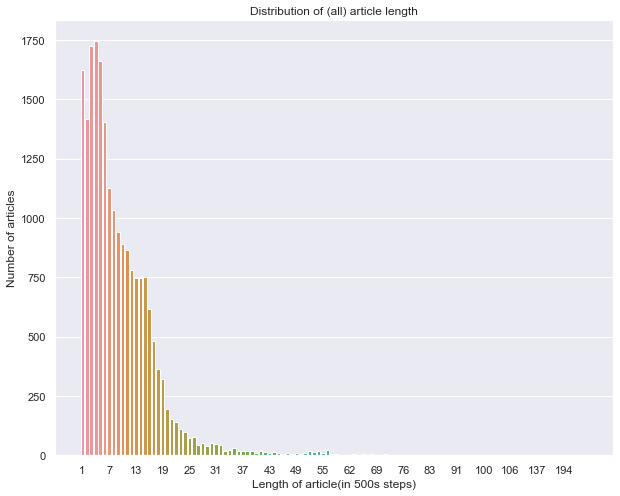

In [98]:
ax = sns.countplot(x=df["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution of (all) article length')

Statistical analysis about length of every fake news (label = 1) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, 'Length of article(in 500s steps)'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Distribution of article length')]

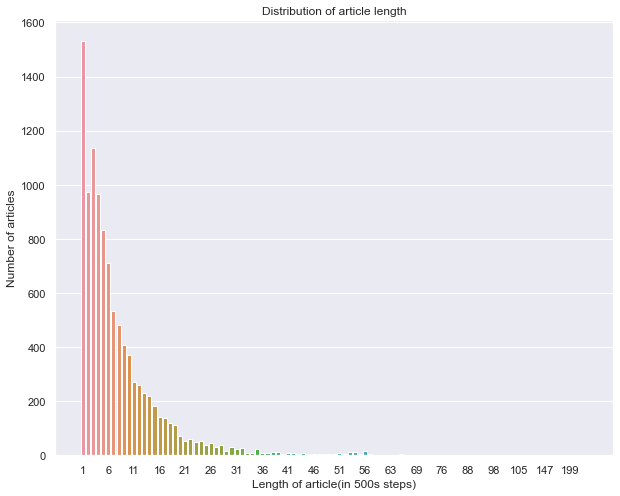

In [99]:
ax = sns.countplot(x=df.loc[df["label"] == 1]["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution of article length')

Statistical analysis about length of every non fake news (label = 0) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, 'Length of article(in 500s steps)'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Distribution of article length')]

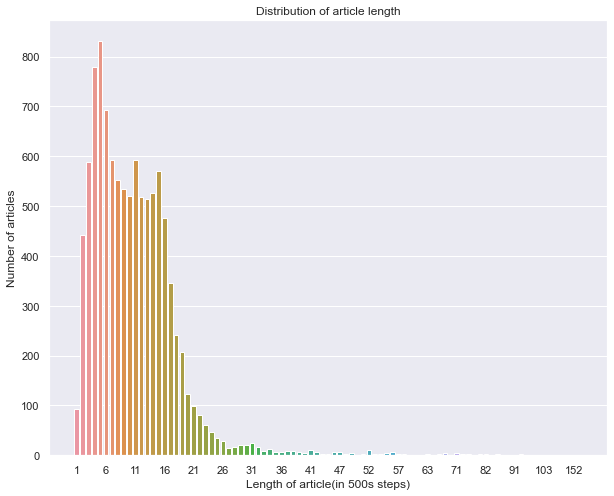

In [100]:
plt.close()
ax = sns.countplot(x=df.loc[df["label"] == 0]["text_length"])
ax.locator_params(axis='x', nbins=20)
ax.set(xlabel = 'Length of article(in 500s steps)', ylabel='Number of articles', title='Distribution of article length')

Check amount of names and save result to CSV file.

In [102]:
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []

    return len(person_list)

""" start_time = time.time()

f = open("../data/name_output.csv", 'w', encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(["article_id","nb_names"])

for id, content in enumerate(df["text"]):
    if id%100==0:
        print(id)
    try:
        writer.writerow([id, len(get_human_names(content))])
    except:
        pass

print(time.time()-start_time)
f.close() """

' start_time = time.time()\n\nf = open("../data/name_output.csv", \'w\', encoding=\'UTF8\', newline=\'\')\nwriter = csv.writer(f)\nwriter.writerow(["article_id","nb_names"])\n\nfor id, content in enumerate(df["text"]):\n    if id%100==0:\n        print(id)\n    try:\n        writer.writerow([id, len(get_human_names(content))])\n    except:\n        pass\n\nprint(time.time()-start_time)\nf.close() '

In [112]:
df["text_names"] = df["text"].apply(lambda x: get_human_names(str(x)))

KeyboardInterrupt: 

Separate number of proper names depending on fake/ non-fake news.
Process CSV file.

In [7]:
df_names = pd.read_csv("../data/name_output.csv")

non_fake = {}
fake = {}

non_fake_sum = 0
fake_sum = 0

total_non_fake = 0
total_fake = 0

for index, row in df_names.iterrows():
    
    if df.loc[df["id"] == row["article_id"], "label"].to_string(index=False) == "1":

        if row["nb_names"] in fake:
            fake[row["nb_names"]]+=1
        else:
            fake[row["nb_names"]] = 1
        fake_sum += row["nb_names"]
        total_fake+=1

    else:
        if row["nb_names"] in non_fake:
            non_fake[row["nb_names"]]+=1
        else:
            non_fake[row["nb_names"]] = 1
        
        non_fake_sum += row["nb_names"]
        total_non_fake+=1

print(f"Non fake news amount: {total_non_fake}  -  Added up number of proper names: {non_fake_sum}  -  Average: {non_fake_sum/total_non_fake}")
print(f"Fake news amount: {total_fake}  -  Added up number of proper names: {fake_sum}  -  Average: {fake_sum/total_fake}")
print(f"All news amount: {total_fake+total_non_fake}  -  Added up number of all proper names: {fake_sum+non_fake_sum}  -  Average: {(fake_sum+non_fake_sum)/(total_fake+total_non_fake)}")


Non fake news amount: 10387  -  Added up number of proper names: 109438  -  Average: 10.53605468373929
Fake news amount: 10374  -  Added up number of proper names: 64132  -  Average: 6.18199344515134
All news amount: 20761  -  Added up number of all proper names: 173570  -  Average: 8.36038726458263


Generate graph for fake news.

[Text(0.5, 0, 'Number of proper names'),
 Text(0, 0.5, 'Amount of articles'),
 Text(0.5, 1.0, 'Fake news graph')]

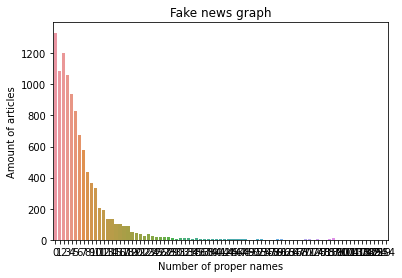

In [8]:
fake_news_df = pd.DataFrame(fake.items())
ax = sns.barplot(x=0, y=1, data=fake_news_df)
ax.set(xlabel = 'Number of proper names', ylabel='Amount of articles', title='Fake news graph')

Generate graph for non fake news.

[Text(0.5, 0, 'Number of proper names'),
 Text(0, 0.5, 'Amount of articles'),
 Text(0.5, 1.0, 'Non Fake news graph')]

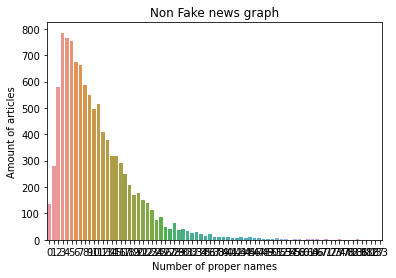

In [9]:
non_fake_news_df = pd.DataFrame(non_fake.items())
ay = sns.barplot(x=0, y=1, data=non_fake_news_df)
ay.set(xlabel = 'Number of proper names', ylabel='Amount of articles', title='Non Fake news graph')